In [1]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch import nn

In [2]:
if torch.cuda.is_available():
    device = "cuda"
    print("Training on GPU")
else:
    device = "cpu"
    print("Training on CPU")

Training on GPU


In [3]:
dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.MNIST('./files', train=False, download=True,
                            transform=torchvision.transforms.ToTensor()),
    torchvision.datasets.MNIST('./files', train=True, download=True, 
                            transform=torchvision.transforms.ToTensor())
                            ])
                               
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Excercise 1. Autoencoder (20%)

Implement an Autoencoder that encodes the MNIST dataset to a latent dimension of size
m < 784. Use Tranposed Convolutions and/or Unpooling to solve this exercise. Train the
Autoencoder and plot the reconstruction training loss. Plot 5 digits (of your choice) before
and after reconstruction. Do this for two different latent dimension sizes.

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True, padding=0)
        self.enc_dense = nn.Linear(7 * 7 * 32, latent_dim)
        self.dec_dense = nn.Linear(latent_dim, 7 * 7 * 32)
        self.unpool = nn.MaxUnpool2d(kernel_size=(2, 2), stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, input_channels, kernel_size=(3, 3), stride=1, padding=1)
        self.latent_dim = latent_dim
        
    def encoder(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x, indices = self.maxpool(x)
        self.up1_indices = indices 
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x, indices = self.maxpool(x)
        self.up2_indices = indices
        x = x.view((x.shape[0], 7 * 7 * 32))
        x = self.enc_dense(x)
        return x
    
        
    def decoder(self, x):
        x = self.dec_dense(x)
        x = x.view((x.shape[0], 32, 7, 7))
        x = self.unpool(x, self.up2_indices)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.unpool(x, self.up1_indices)
        x = self.conv4(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction
    
def fit(latent_dim, num_epochs, data_loader):
    bce_loss = nn.BCELoss()
    model = AutoEncoder(1, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    model.train()
    for epoch in range(1, num_epochs + 1):
        running_loss = 0
        iterations = 0
        for x, _ in data_loader:
            x = x.to(device)
            optimizer.zero_grad()
            reconstruction = model(x)
            loss = bce_loss(reconstruction, x)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            iterations += 1

        cur_loss = running_loss / iterations
        losses.append(cur_loss)
        print(f"Epoch {epoch}/{num_epochs} ==> loss: {cur_loss}")
        
    return model, losses

In [5]:
LATENT_DIM_SMALL = 2
LATENT_DIM_LARGE = 25
NUM_EPOCHS = 10

print(f"TRAINING ON {LATENT_DIM_SMALL} DIMENSIONAL LATENT SPACE")
print("-" * 45)
m_small, m_small_losses  = fit(LATENT_DIM_SMALL, NUM_EPOCHS, data_loader)
print()
print(f"TRAINING ON {LATENT_DIM_LARGE} DIMENSIONAL LATENT SPACE")
print("-" * 45)
m_large, m_large_losses = fit(LATENT_DIM_LARGE, NUM_EPOCHS, data_loader)

TRAINING ON 2 DIMENSIONAL LATENT SPACE
---------------------------------------------
Epoch 1/10 ==> loss: 0.15364076432787305
Epoch 2/10 ==> loss: 0.08546457710715055
Epoch 3/10 ==> loss: 0.07836923102628596
Epoch 4/10 ==> loss: 0.07735550737304706
Epoch 5/10 ==> loss: 0.0759277696528862
Epoch 6/10 ==> loss: 0.07461761837140733
Epoch 7/10 ==> loss: 0.07401234227516969
Epoch 8/10 ==> loss: 0.0735102904453138
Epoch 9/10 ==> loss: 0.07306555692630887
Epoch 10/10 ==> loss: 0.07271928036452648

TRAINING ON 25 DIMENSIONAL LATENT SPACE
---------------------------------------------
Epoch 1/10 ==> loss: 0.12552762107831686
Epoch 2/10 ==> loss: 0.07361306651909129
Epoch 3/10 ==> loss: 0.0702331705492201
Epoch 4/10 ==> loss: 0.06889305650588581
Epoch 5/10 ==> loss: 0.06795584498964237
Epoch 6/10 ==> loss: 0.06724044835191541
Epoch 7/10 ==> loss: 0.06661914141211911
Epoch 8/10 ==> loss: 0.06611663498788037
Epoch 9/10 ==> loss: 0.0657378684327524
Epoch 10/10 ==> loss: 0.06544758821454519


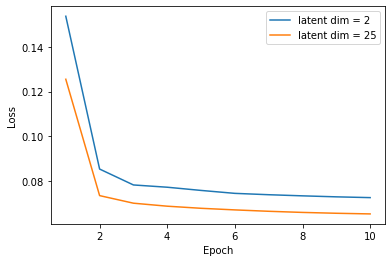

In [6]:
plt.plot(list(range(1, len(m_small_losses) + 1)), m_small_losses, label=f"latent dim = {LATENT_DIM_SMALL}")
plt.plot(list(range(1, len(m_large_losses) + 1)), m_large_losses, label=f"latent dim = {LATENT_DIM_LARGE}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
m_small.eval()
m_large.eval()
for x, _ in data_loader:
    with torch.no_grad():
        x = x.to(device)
        orig = x
        rec_sm = m_small(x)
        rec_lg = m_large(x)
        break

In [8]:
orig = orig.cpu().numpy()
rec_sm = rec_sm.cpu().numpy()
rec_lg = rec_lg.cpu().numpy()

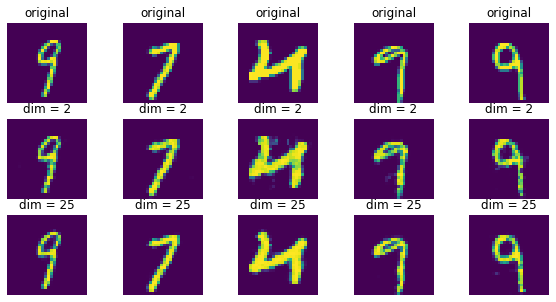

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 5))
for experiment in range(3):
    for col in range(ax.shape[1]):
        ax[experiment][col].axis('off')
        if experiment == 0:
            ax[experiment][col].imshow(orig[col].reshape(28, 28))
            ax[experiment][col].set_title(f"original")
        elif experiment == 1:
            ax[experiment][col].imshow(rec_sm[col].reshape(28, 28))
            ax[experiment][col].set_title(f"dim = {LATENT_DIM_SMALL}")
        else:
            ax[experiment][col].imshow(rec_lg[col].reshape(28, 28))
            ax[experiment][col].set_title(f"dim = {LATENT_DIM_LARGE}")

# Excercise 2. Variational Autoencoder
Now that you have built an Autoencoder, it is time to implement a Variational Autoencoder.
You can use the Autoencoder you trained in the previous exercise and adapt it for this
exercise. Do not forget to use the reparametrization trick for sampling from Z-space.

In [10]:
class  VariationalAutoEncoder(nn.Module):
    def __init__(self, input_channels, latent_dim, device):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.enc_mean = nn.Linear(7 * 7 * 32, latent_dim)
        self.enc_std = nn.Linear(7 * 7 * 32, latent_dim)
        self.dec_dense = nn.Linear(latent_dim, 7 * 7 * 32)
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, input_channels, kernel_size=(3, 3), stride=2, padding=1, output_padding=1)
        self.latent_dim = latent_dim
        self.device = device
        
    def encoder(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = x.view((x.shape[0], 7 * 7 * 32))
        mean = self.enc_mean(x)
        std = self.enc_std(x)
        return mean, std
    
        
    def decoder(self, x):
        x = self.dec_dense(x)
        x = nn.functional.relu(x)
        x = x.view((x.shape[0], 32, 7, 7))
        x = self.deconv1(x)
        x = nn.functional.relu(x)
        x = self.deconv2(x)
        x = torch.sigmoid(x)
        return x
    
    def reparameterise(self, mean, std):
        eps = torch.normal(torch.zeros_like(mean), torch.ones_like(std))
        return eps * std + mean
        
    def forward(self, x):
        mean, std = self.encoder(x)
        latent = self.reparameterise(mean, std)
        reconstruction = self.decoder(latent)
        return reconstruction, mean, std
    
    def generate(self, num_samples):
        with torch.no_grad():
            eps = torch.normal(torch.zeros((num_samples, self.latent_dim)), torch.ones((num_samples, self.latent_dim))).to(self.device)
            return self.decoder(eps)

def kl_divergence(mean, std):
    variance = std * std
    return torch.sum(mean * mean + variance - 1 - torch.log(variance))
    

a) Train a Variational Autoencoder with latent dimension of size 2. Then, plot the digits
where their associated position was in latent space similarly as explained in the lecture.
(25%)

In [19]:
bce_loss = nn.BCELoss(reduction='sum')
model = VariationalAutoEncoder(1, 2, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

losses = []
kl_losses = []
reconstruction_losses = []

model.train()
for epoch in range(1, num_epochs + 1):
    running_reconstruction_loss = 0
    running_kl_loss = 0
    iterations = 0
    for x, _ in data_loader:
        x = x.to(device)
        optimizer.zero_grad()
        reconstruction, mean, std = model(x)
        kl_loss = kl_divergence(mean, std)
        reconstruction_loss = bce_loss(reconstruction, x)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        running_reconstruction_loss += reconstruction_loss.item()
        running_kl_loss += kl_loss.item()
        iterations += 1
        
    kl_loss = running_kl_loss / iterations
    reconsruction_loss = running_reconstruction_loss / iterations
    cur_loss = kl_loss + reconstruction_loss
    kl_losses.append(kl_loss)
    reconstruction_losses.append(reconsruction_loss)
    losses.append(cur_loss)
    print(f"Epoch {epoch}/{num_epochs} ==> kl_loss:{kl_loss}, reconstruction_loss: {reconsruction_loss}, loss: {cur_loss}")

Epoch 1/10 ==> kl_loss:1321.8147464173367, reconstruction_loss: 28678.099937871342, loss: 22573.884765625
Epoch 2/10 ==> kl_loss:1013.9868242169647, reconstruction_loss: 22734.882273337524, loss: 20165.759765625
Epoch 3/10 ==> kl_loss:1011.1445704151552, reconstruction_loss: 21731.432147651965, loss: 18603.68359375
Epoch 4/10 ==> kl_loss:1024.7406866153808, reconstruction_loss: 21124.640335780394, loss: 18809.88671875
Epoch 5/10 ==> kl_loss:1043.7954720840594, reconstruction_loss: 20760.821333695156, loss: 19377.244140625
Epoch 6/10 ==> kl_loss:1065.410920807387, reconstruction_loss: 20516.4081745601, loss: 19889.244140625
Epoch 7/10 ==> kl_loss:1043.1492019458053, reconstruction_loss: 20718.90607503999, loss: 19101.798828125
Epoch 8/10 ==> kl_loss:1000.7448954747844, reconstruction_loss: 21202.73643167276, loss: 18413.041015625
Epoch 9/10 ==> kl_loss:1203.510578943563, reconstruction_loss: 22922.022809072212, loss: 20186.2578125
Epoch 10/10 ==> kl_loss:1137.883026736746, reconstructio

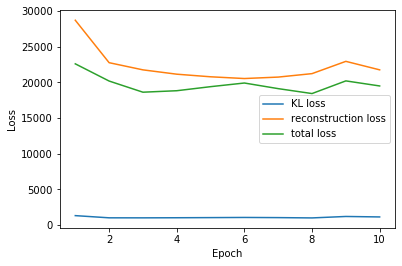

In [20]:
plt.plot(list(range(1, num_epochs + 1)), kl_losses, label="KL loss")
plt.plot(list(range(1, num_epochs + 1)), reconstruction_losses, label="reconstruction loss")
plt.plot(list(range(1, num_epochs + 1)), losses, label="total loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
model.eval()
samples = model.generate(128)

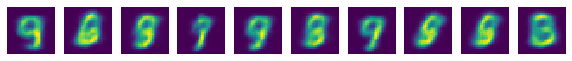

In [22]:
samples = samples.cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
for col in range(ax.shape[0]):
    ax[col].axis('off')
    ax[col].imshow(samples[col].reshape((28, 28)))

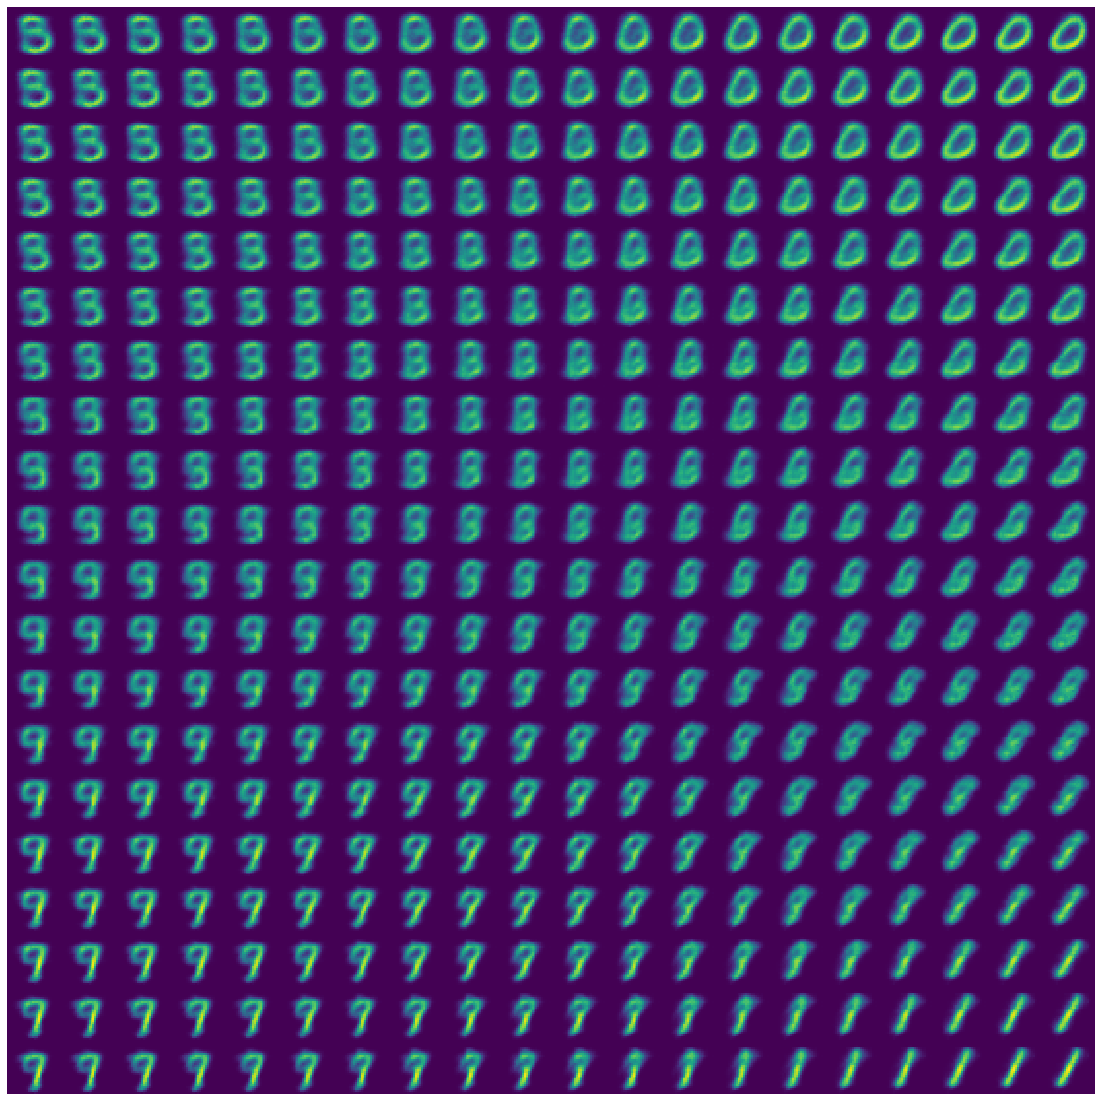

In [23]:
STEPS = 20
img = np.zeros((STEPS * 28, STEPS * 28))
for row, d_1 in enumerate(np.linspace(-2, 2,STEPS)):
    for col, d_2 in enumerate(np.linspace(-2, 2,STEPS)):
        x = torch.tensor([[d_1, d_2]]).float().to(device)
        with torch.no_grad():
            sample = model.decoder(x)
        sample = sample.cpu().numpy().reshape((28, 28))
        img[row * 28: (row + 1) * 28, col * 28: (col + 1) * 28] = sample

plt.figure(figsize = (20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

b) Plot the variance vector of the decoder for a single input as an image (in digit space;
[3,28,28]). What is the interpretation of that? (25%)

We don't really know how to do this, probably because we used binary crossentropy instead of the reconstruction loss function defined in the lecture, we will plot the variance vector we obtained from the encoder step.

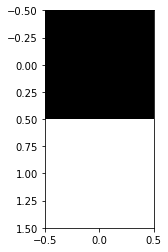

In [24]:
std = std.detach().cpu().numpy()
var = std * std
var_sample = var[0].reshape((-1, 1))
plt.imshow(var_sample, cmap='gray')